In [1]:
%load_ext autoreload
import sys
sys.path.append('../..')

In [2]:
import numpy as np

In [3]:
import cv2
import os
import pandas as pd

# Extract Video Frames

In [40]:
video_path = '/home/paulo/Vídeos/starwars.mp4'

In [41]:
dir_path = video_path.split('.')[0]

In [42]:
cap=cv2.VideoCapture(video_path)

In [43]:
fps = int(round(cap.get(cv2.CAP_PROP_FPS)))

In [44]:
fps

24

In [ ]:
if os.path.isdir(dir_path):
    os.rmdir(dir_path)
os.mkdir(dir_path)

In [ ]:
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i%fps == 0:
        cv2.imwrite(f'{dir_path}/frame_{i}.jpg',frame)
    i+=1

## Get urls

In [ ]:
from faces_clustering import get_files_folder, FeatureExtractor

In [ ]:
from tqdm import tqdm

In [ ]:
extractor = FeatureExtractor('senet50')

In [ ]:
frames_url = get_files_folder(dir_path)

In [ ]:
faces_dict = {}
for url in tqdm(frames_url):
    faces_dict[url] = extractor.get_embeddings(url)


In [ ]:
all_urls = []
all_faces = []
all_embs = []
for url in frames_url:
    embs, faces = faces_dict[url]
    for emb, face in zip(embs, faces):
        all_urls.append(url)
        all_faces.append(face)
        all_embs.append(emb)

In [ ]:
dt_sw = pd.DataFrame(all_urls, columns=['urls'])

In [ ]:
dt_sw['embeddings'] = all_embs
dt_sw['faces'] = all_faces

In [ ]:
dt_sw.head()

In [ ]:
dt_sw.to_pickle('/home/paulo/Documentos/video.pkl')

# Clustering

In [4]:
from faces_clustering import Clusterer, silhuoette

Using TensorFlow backend.


In [5]:
dt_sw = pd.read_pickle('/home/paulo/Documentos/video.pkl')
dt_sw.shape

(1019, 3)

In [6]:
dt_sw.loc[dt_sw['urls']=='/home/paulo/Vídeos/starwars/frame_240.jpg']

,urls,embeddings,faces
698,/home/paulo/Vídeos/starwars/frame_240.jpg,-,-


In [7]:
valid = dt_sw.embeddings.apply(lambda x: str(x) != '-')
dt_sw = dt_sw.loc[valid]

In [8]:
dt_sw.shape

(885, 3)

In [9]:
embs = [list(emb) for emb in dt_sw.embeddings.values]


Computing clusters from 2 to 36


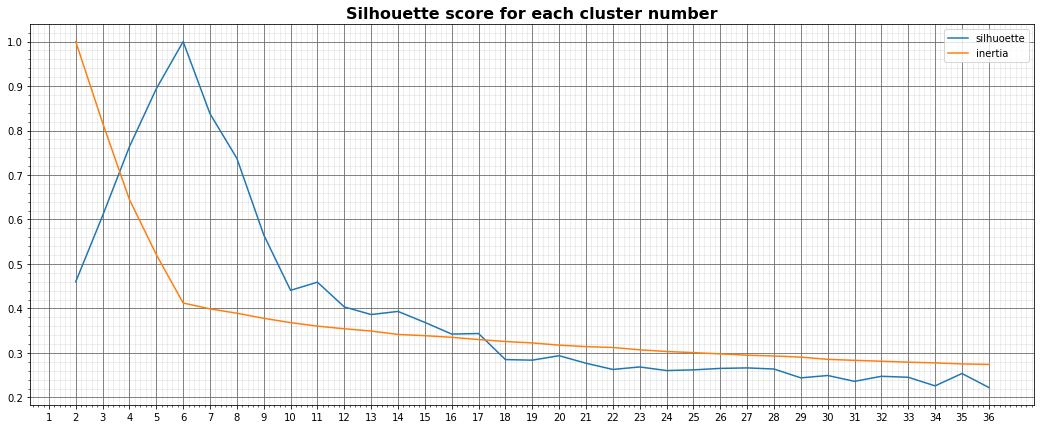

In [11]:
silhuoette(embs,np.arange(2,37))

In [19]:
alg = 'kmeans'

In [20]:
clusterer = Clusterer(n_clusters = 6, face_embeddings = dt_sw,algs=[alg])

In [21]:
clusters, _ = clusterer.clusterize()

In [22]:
clusters.head()

,urls,embeddings,faces,cluster_kmeans
0,/home/paulo/Vídeos/starwars/frame_2328.jpg,"[0.0069940784, 3.6740913, 7.053296, 6.8567324,...","[[[113, 105, 105], [113, 107, 105], [112, 107,...",1
1,/home/paulo/Vídeos/starwars/frame_2328.jpg,"[0.13643333, 7.022257, 0.1115102, 0.022800043,...","[[[63, 47, 48], [61, 45, 47], [59, 43, 46], [5...",0
2,/home/paulo/Vídeos/starwars/frame_9936.jpg,"[0.059948366, 2.2146533, 0.03107408, 0.0489270...","[[[94, 93, 107], [83, 82, 96], [65, 64, 80], [...",5
3,/home/paulo/Vídeos/starwars/frame_9936.jpg,"[0.0055236802, 7.9716144, 0.04607724, 0.204812...","[[[134, 97, 90], [137, 99, 93], [139, 102, 95]...",2
4,/home/paulo/Vídeos/starwars/frame_5136.jpg,"[0.017639088, 2.7237387, 0.03603873, 0.0815966...","[[[78, 60, 56], [77, 59, 55], [75, 57, 53], [7...",0


In [29]:
faces_samples = clusters[[f'cluster_{alg}','faces']].sort_values(
    f'cluster_{alg}').groupby(f'cluster_{alg}').head(1).faces.values

In [175]:
colors = list(np.random.random(size=(len(faces_samples),3)) * 256)

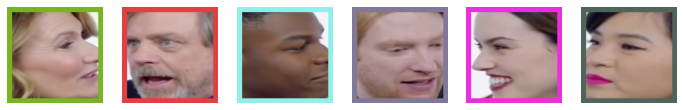

In [176]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(faces_samples), figsize=(12, 7))
#fig.tight_layout()
#fig.subplots_adjust(hspace=0, wspace=0)
i = 0
for sample in faces_samples:
    #axes.figure(figsize=(2,3))
    image = cv2.rectangle(sample, (0,0), sample.shape[0:2], colors[i], int(sample.shape[0]/10))
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_aspect('equal')
    i = i+1

# Clusters by frame

In [82]:
clusters_urls = clusters[[f'cluster_{alg}','urls']]

In [83]:
frames = clusters_urls.urls.apply(lambda x: int(x.split('.')[0].split('/')[-1].split('_')[-1]))

In [84]:
clusters_frames = clusters_urls[[f'cluster_{alg}']]

In [85]:
clusters_frames['frames'] = frames

In [86]:
cluster_by_frames = clusters_frames.groupby('frames')[f'cluster_{alg}'].apply(list)

In [87]:
cluster_by_frames = cluster_by_frames.apply(np.sort)

In [88]:
cluster_by_frames = pd.DataFrame(cluster_by_frames)

In [125]:
cluster_by_frames.head()

,cluster_kmeans
frames,
24,[1]
48,[1]
72,[3]
96,"[2, 5]"
120,[5]


# Display Timeline

In [99]:
import matplotlib.gridspec as gridspec
from tqdm import tqdm

In [178]:
def draw_lines(frame, clusters):
    thumb = f'/home/paulo/Vídeos/starwars/frame_{frame}.jpg'
    img = cv2.imread(thumb)
    test = img[:,:,::-1].copy()
    for c in clusters:

        line_thickness = int((img.shape[0]/3)/len(faces_samples))

        test = cv2.line(test, (0,test.shape[0]-line_thickness*(c+1)), 
                 (img.shape[1]-1,test.shape[0]-line_thickness*(c+1)), colors[c], thickness=line_thickness)

    return test

100%|██████████| 60/60 [00:03<00:00, 16.71it/s]


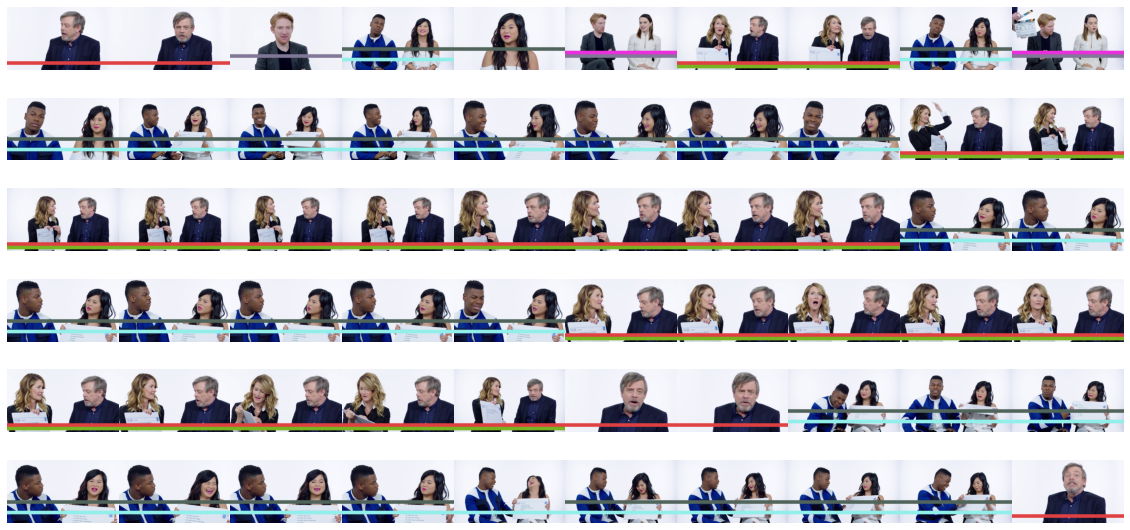

In [184]:
plt.figure(figsize = (20,100))
gs1 = gridspec.GridSpec(60, 10)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 
i = 0
for frame in tqdm(cluster_by_frames.head(60).index.values):
    thumb = draw_lines(frame, cluster_by_frames.loc[frame][0])
    
    ax1 = plt.subplot(gs1[i])  
    plt.subplots_adjust(hspace=0, wspace=0)
    ax1.imshow(thumb)
    ax1.axis('off')
    #ax1.set_aspect('equal')
    
    i = i + 1